In [1]:
import numpy as np
import pandas as pd
from dataloaders import *
from utils import *
from EDA import *
import config

## Feature Extraction

In [ ]:
dataset_dir = config.dataset_dir

for subject_id in range(10):
    subject_id += 1

    for sic_candidate in range(30):
        sic_candidate += 1
        
        print('\nSubject ID:',subject_id,'\nsIC:',sic_candidate)

        bold, _ = data_import(dataset    = dataset_dir,
                                subject_id = subject_id,
                                subfolder  = 'pre_bold\\pre_bold_preprocessed.ica',
                                data_name  = ['filtered_func_data'])

        fmri_data = bold['filtered_func_data'].get_fdata()

        sica, _ = data_import(dataset    = dataset_dir,
                                subject_id = subject_id,
                                subfolder  = 'pre_bold\\pre_bold_preprocessed.ica\\filtered_func_data.ica',
                                data_name  = ['mask','melodic_IC'])

        selected_ic = ic_extract(sica['melodic_IC'],sic_candidate)

        _, selected_ic_cluster = ic_browse(selected_ic = selected_ic,
                                            criterion   = selected_ic >= 3.1,
                                            affine      = sica['melodic_IC'].affine,
                                            show        = False)

        selected_ic_cluster = morphological_operation(selected_ic_cluster)

        max_value, _ = ic_browse(selected_ic = selected_ic,
                                    criterion   = selected_ic >= selected_ic.max(),
                                    affine      = sica['melodic_IC'].affine,
                                    show        = False)
        
        max_value_fmri = fmri_data[max_value["Max_index"][0]]
        max_area_fmri = mean_fmri_in_neighborhood(fmri_data, max_value["Max_index"][0], 3)
        selected_ic_mask = mask_cc_around_coordinate(selected_ic_cluster, max_value["Max_index"][0])
        
        R_outside_inside = outside_inside_ratio(selected_ic, sica['mask'])
        max_power_freq = max_power_frequency(max_area_fmri, tr=3.0)
        LI_result = lateralization_index(selected_ic)
        BLI_result = binary_lateralization(selected_ic_cluster)
        connectivity_matrix = cluster_connectivity_ds(fmri_data, selected_ic_mask, ds_target=32)
        central_network_strength = voxel_network_strength(fmri_data, selected_ic_mask, max_value["Max_index"][0])
        random_matrices = generate_random_matrices(connectivity_matrix, num_random_matrices=500)
        TM_result = compute_topological_measures(connectivity_matrix, random_matrices)
        
        sIC_Features = {
            'Subject ID': subject_id,
            'sIC Number': sic_candidate,
            'sIC Center': max_value['MNI_coords'],
            'R_o/i': R_outside_inside,
            'Max Power Frequency': max_power_freq,
            'Lateralization Index': LI_result['Lateralization Index'],
            'Lateralization Strength': BLI_result['Lateralization Strength'],
            'Lateralization Side': BLI_result['Side'],
            'Centeral Network': central_network_strength,
            'Clustering Coefficient': TM_result['Clustering Coefficient'],
            'Characteristic Path Length': TM_result['Characteristic Path Length'],
            'Local Efficiency': TM_result['Local Efficiency'],
            'Connectivity Strength': TM_result['Connectivity Strength'],
            'Connectivity Diversity': TM_result['Connectivity Diversity'],  
        }

        df = pd.DataFrame(sIC_Features, index=[0])
        results_path = f'results/Sub{subject_id}_sIC_Features.csv'

        if os.path.isfile(results_path):
            df.to_csv(results_path, mode='a', index=False, header=False)
        else:
            df.to_csv(results_path, index=False, header=True)

In [ ]:
directory_path = 'results'
output_file = 'sIC_Features.csv'
merge_csv_files(directory_path, output_file)

## Feature Selection

In [2]:
# to_see = [(1,16),(3,18),(3,19),(9,11),(10,17)]
# mirror_ics = [(1,4),(2,24),(4,25),(10,16)]
# ez_ics = [(1,25),(2,17),(3,13),(4,15),(4,18),(5,29),(6,29),(7,26),(7,27),(8,25),(8,22),(8,4),(9,20),(10,9),(10,4)]

In [3]:
data = pd.read_csv('results/sIC_Features.csv')
df = pd.DataFrame(data)
to_see = [(1,16),(3,18),(3,19),(9,11),(10,17)]
mirror_ics = [(1,4),(2,24),(4,25),(10,16)]
ez_ics = [(1,25),(2,17),(3,13),(4,15),(5,29),(6,29),(7,26),(8,25),(9,20),(10,9)]
pairs_df = pd.DataFrame(ez_ics, columns=['Subject ID', 'sIC Number'])
filtered_df = pd.merge(df, pairs_df, on=['Subject ID', 'sIC Number'], how='inner')
filtered_df.to_csv('results/ezIC_Features.csv', index=False)

## Feature Visualization

In [4]:
ics = pd.DataFrame(pd.read_csv("results/sIC_Features.csv"))
ez_ics = pd.DataFrame(pd.read_csv("results/ezIC_Features.csv"))
feature_names = ics.columns.drop(['Subject ID','sIC Number','sIC Center','R_o/i','Lateralization Index','Lateralization Side','Characteristic Path Length','Local Efficiency'])

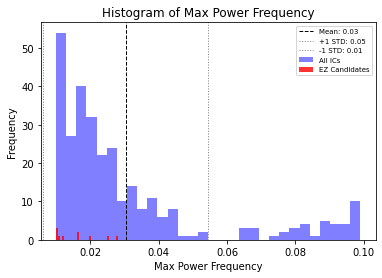

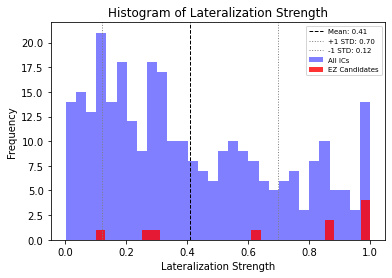

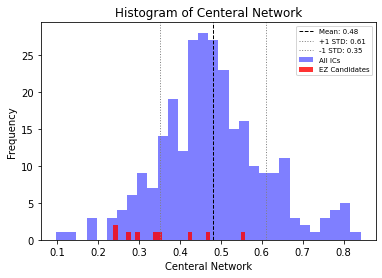

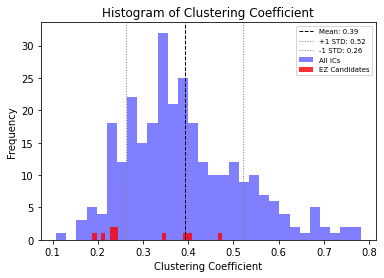

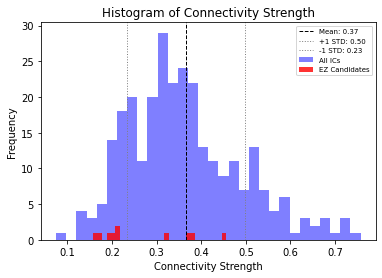

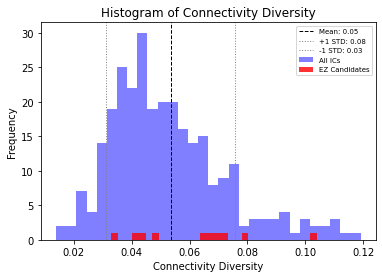

In [5]:
for feature in feature_names: histplot_feature(ics, ez_ics, feature)

c:\Users\Mostafa\OneDrive\Documents\Projects\Papers\Spatio-Temporal Component-based Functional Connectivity (stCBFC) for Epileptic Foci Localization\Repository\utils\plot_features.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means = df.mean() ; stds = df.std()


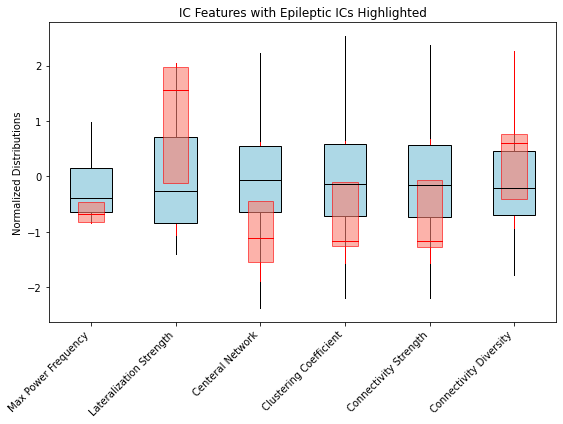

In [6]:
boxplot_features(ics, ez_ics, feature_names, norm=True)